# **Projet d'analyse de la couverture végétale**

Dans ce document je résume mes principaux résultats et ce que j'ai tenté/réussi à réaliser.

- **Importation des modules nécessaires pour les codes**

In [78]:
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# On élargit un peu les fenêtres d'affichage de matplotlib.
plt.rcParams["figure.figsize"] = (9,6)

# On charge notre package.
import satellite as sat
from satellite import Ocli
oc = sat.Ocli()

# On charge les modules necessaire pour prédire Fcover à partir d'un modèle regressif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

        J'ai créé une fonction qui à partir des fichiers .nc créée un fichier FCOVERtableNomZone.csv avec la date le chemain du fichier .nc, sa révision et enfin le taux de végétation (la valeur du FCOVER).
J'ai voulu télécharger plus de fichier .nc pour pouvoir afficher l'evolution du taux de végétation sur une période plus longue (quelques années) mais le site pour télécharger les données satellitaire a changer en plus je suis actuellement au Maroc (le débit d'internet est insuffisant pour télécharger les fichiers voulus, ça me prendrai environ de 5 jours de téléchargement).

In [79]:
oc.FCOVER('Ile de France')
oc.FCOVER('Moyen Atlas')

### **Visualisation du taux de couverture végétale avec les images optiques**

In [80]:
oc.iplot()

interactive(children=(Dropdown(description='date', options=('20-11-2023', '30-11-2023', '10-12-2023', '31-12-2…

In [81]:
# accès au répertoire Barro-Alto
zonedir = os.path.realpath(
    os.path.join(
    os.path.dirname(sat.EARTHDIR),'..','Barro-Alto'))
print(zonedir)

C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee\satellite\data\zones\Barro-Alto


### **Récupération des données optiques et radar à partir des fichiers FCOVERtable.csv et RVItable.csv** 

In [82]:
# Accès au données du fichier RVItable.csv
df = pd.read_csv(os.path.join(zonedir,'RVItable.csv'))
df.set_index('DATE', drop=True, inplace=True)
df.index = pd.to_datetime(df.index)

# Accès au données du fichier FCOVERtable.csv
df2 = pd.read_csv(os.path.join(zonedir,'FCOVERtable.csv'))
df2.set_index('DATE', drop=True, inplace=True)
df2.index = pd.to_datetime(df2.index)

### **Affichage des données RVI brut dans une courbe**

Text(0, 0.5, 'RVI')

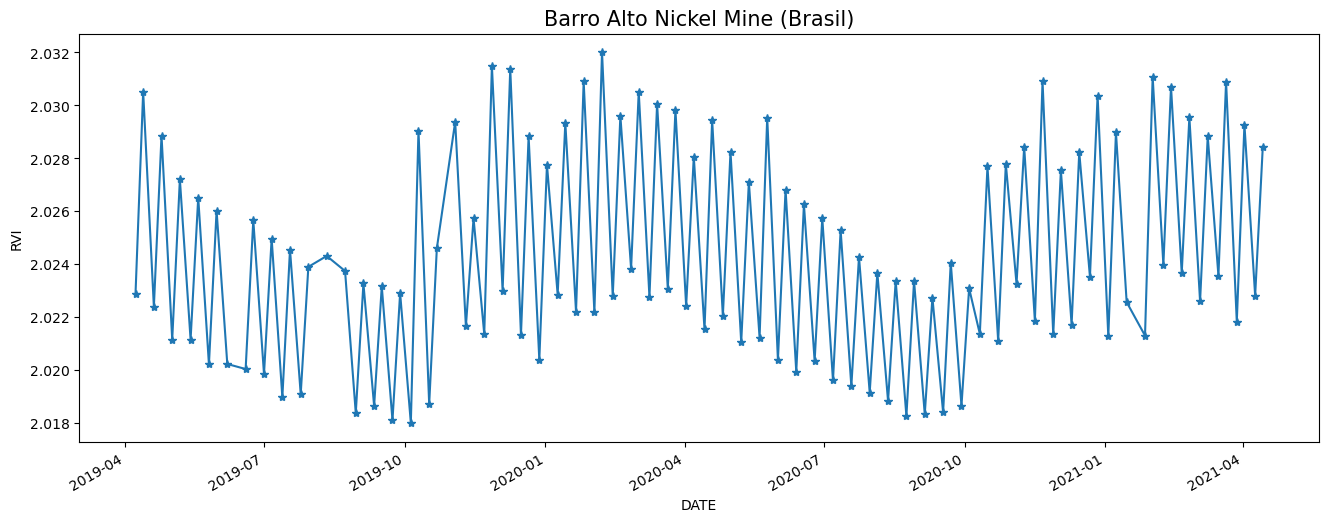

In [83]:
fig,ax = plt.subplots(figsize = (16,6))
x = df.index
y_RVI = df['RVI']
y_RVI.plot(style='*-')
plt.title('Barro Alto Nickel Mine (Brasil)',fontsize=15)
plt.ylabel('RVI')

### **Affichage des données DLAT et DLON dans une courbe**

[Text(0, 0.5, 'DLAT')]

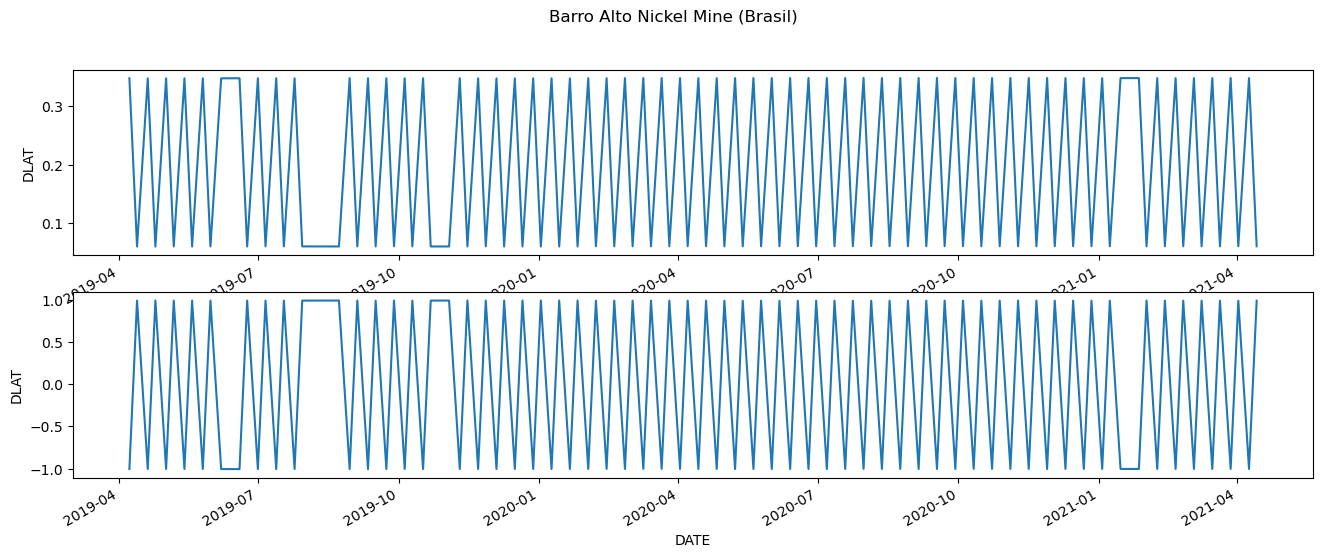

In [84]:
fig,(ax1,ax2) = plt.subplots(2,figsize = (16,6))
fig.suptitle('Barro Alto Nickel Mine (Brasil)')
x = df.index
y_DLAT = df['DLAT']
y_DLON = df['DLON']
y_DLAT.plot(ax = ax1)
y_DLON.plot(ax = ax2)
ax1.set(ylabel = 'DLAT')
ax2.set(ylabel = 'DLAT')

### **Affichage des données FCOVER et RVI dans une courbe**

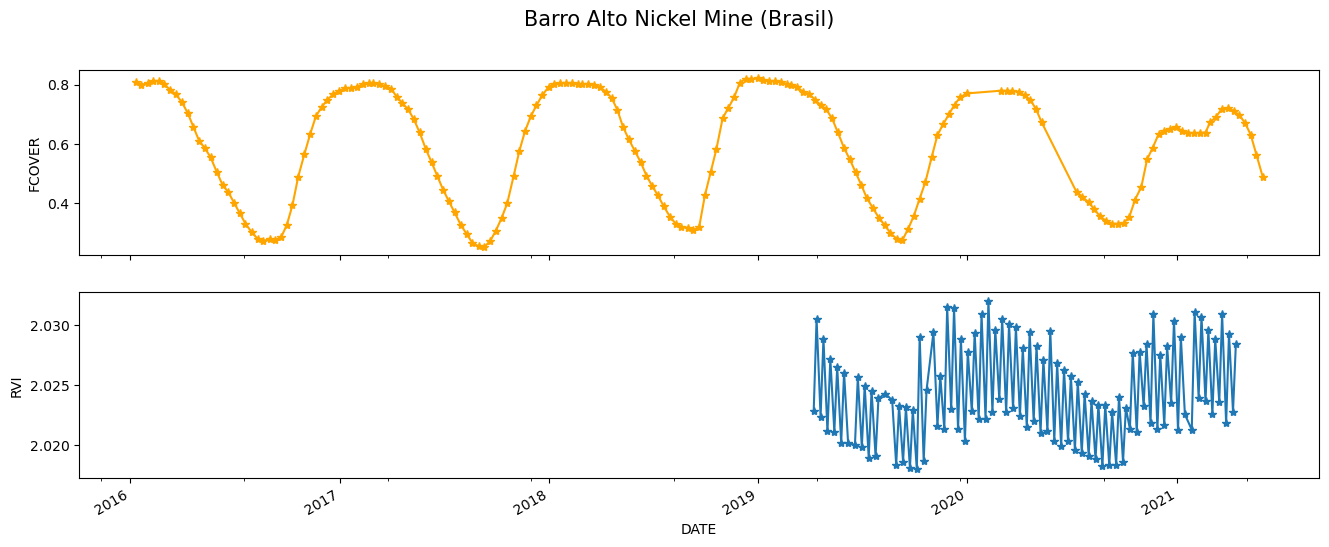

In [85]:
fig,ax = plt.subplots(2,sharex =True,figsize = (16,6))

y_FCOVER = df2['FCOVER']

y_FCOVER.plot(ax=ax[0],style='*-',color="orange")
y_RVI.plot(ax=ax[1],style='*-')

fig.suptitle('Barro Alto Nickel Mine (Brasil)',fontsize=15)

ax[0].set(ylabel = 'FCOVER')
ax[1].set(ylabel = 'RVI')

plt.show()


### **Affichage de FCOVER avec une marge d'erreur de 1% (+/- 3*l'écart type)**

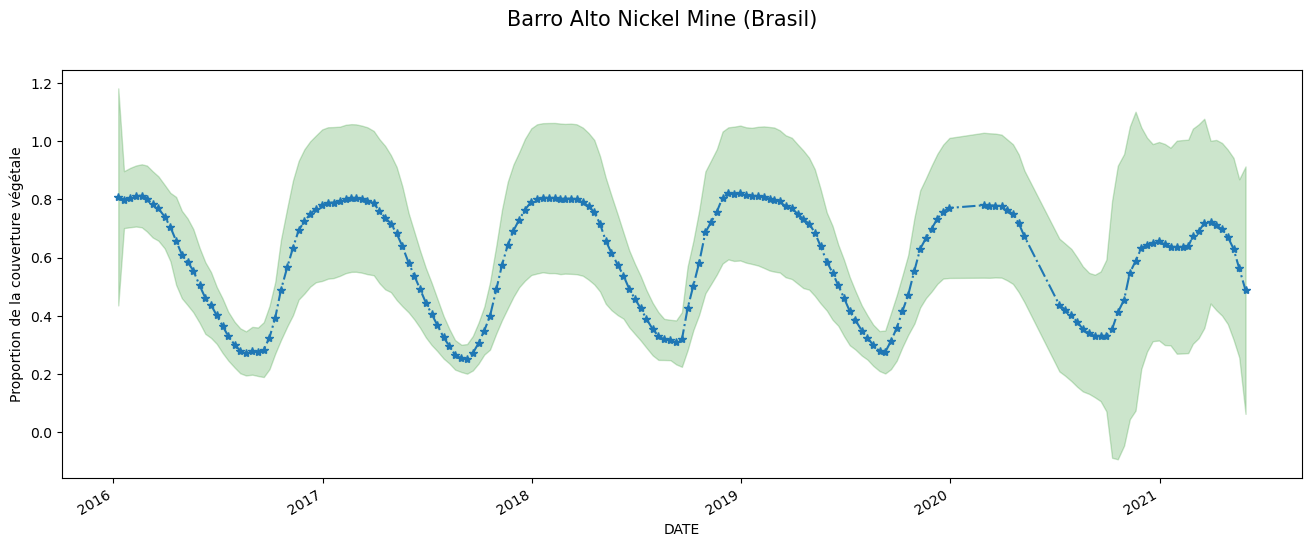

In [86]:
fig,ax = plt.subplots(figsize = (16,6))
x = df2.index

e = df2["RMSE"]
y_FCOVER.plot(style='*-.')
fig.suptitle('Barro Alto Nickel Mine (Brasil)',fontsize=15);
ax.fill_between(x,y_FCOVER-3*e,y_FCOVER+3*e,color='g',alpha=0.2)
# Adjusted line for plotting 'r'

ax.set(ylabel = 'Proportion de la couverture végétale');
plt.show()

### **On fusionne les deux dataFrames pour qu'ils aient les même indices temporelles sur une tolérance de cinq jours**

In [87]:
# Utilisons une jointure 'asof' pour aligner les données de manière plus flexible, j'ai pris une tolérance de 5 jours car sinon j'arrive pas à fusionner les dataFrames avec un minimum de données valables
df_aligned = pd.merge_asof(df.sort_index(), df2.sort_index(), left_index=True, right_index=True, direction='nearest', tolerance=pd.Timedelta('5D'))

# Supprimer les lignes où 'FCOVER' est NaN
df_aligned_clean = df_aligned.dropna(subset=['FCOVER'])

# Affichons le nombre de lignes et les premières lignes du df_aligned pour inspecter
print("Nombre d'enregistrements après jointure 'asof':", len(df_aligned_clean))
print(df_aligned_clean.head())

Nombre d'enregistrements après jointure 'asof': 103
                 RVI    RMSE_x  INCIDENCE  ELEVATION  DIRECTION      DLAT  \
DATE                                                                        
2019-04-08  2.022880  0.014757  45.177209  39.718881         -1  0.348049   
2019-04-13  2.030516  0.020464  32.315486  28.789817         -1  0.059303   
2019-04-20  2.022383  0.014615  45.171332  39.713658         -1  0.347935   
2019-04-25  2.028855  0.018965  32.306826  28.782296         -1  0.059273   
2019-05-02  2.021148  0.013618  45.172762  39.714986         -1  0.347987   

                DLON       DX      DY  \
DATE                                    
2019-04-08 -1.002555  11381.5 -1208.0   
2019-04-13  0.987514 -10136.0 -3043.0   
2019-04-20 -1.002663  11390.0 -1208.0   
2019-04-25  0.988726 -10146.0 -3043.0   
2019-05-02 -1.002477  11380.5 -1208.0   

                                                      ZIPFILE      RVIC  \
DATE                                         

### **Prédiction des valeurs de FCOVER à l'aide des données radars. Ici j'utilise une regression linéaire pour réaliser le modèle**

In [88]:
# Répétez la division des données en ensembles d'entraînement et de test
X = df_aligned_clean[['RVI', 'INCIDENCE', 'ELEVATION', 'DLAT', 'DLON']]
y = df_aligned_clean['FCOVER']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement du modèle
model = LinearRegression()
model.fit(X_train, y_train)

# Prédiction et évaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
y_pred = model.predict(X)


Mean Squared Error (MSE): 0.012116591535558888
R-squared (R2): 0.4782741906797957


### **Préparation et affichage d'un graphique comparatif des valeurs réelles et prédites de la couverture végétale (FCOVER) avec un intervalle de confiance basé sur l'ecart type de la zone (RMSE)**

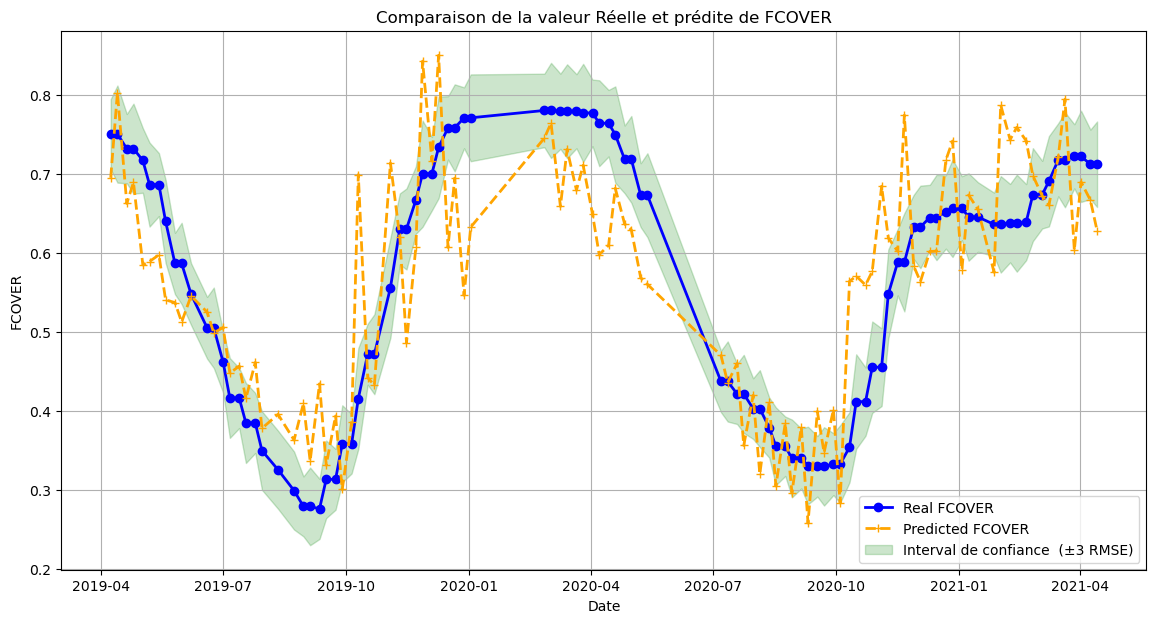

In [89]:
# Préparer les données pour le plot
dates = X.index 
sorted_indices = dates.argsort() 
rmse = df_aligned_clean['RMSE_x'].iloc[sorted_indices]
# Création d'un graphique pour comparer les valeurs réelles et prédites
plt.figure(figsize=(14, 7))
plt.plot(dates, y.iloc[sorted_indices], color='blue', label='Real FCOVER', marker='o', linewidth=2, linestyle='-')
plt.plot(dates, y_pred[sorted_indices], color='orange', label='Predicted FCOVER', marker='+', linewidth=2, linestyle='--')
plt.fill_between(dates, y.iloc[sorted_indices] - 3*rmse, y.iloc[sorted_indices] + 3*rmse, color='green', alpha=0.2, label='Interval de confiance  (±3 RMSE)')
# Ajout de détails au graphique
plt.title('Comparaison de la valeur Réelle et prédite de FCOVER')
plt.xlabel('Date')
plt.ylabel('FCOVER')
plt.legend()
plt.grid(True)

# Affichage du graphique
plt.show()
